In [48]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


# Initialize an empty list to store the results
results = []

# Define the path to the logs directory
logs_dir = '../logs/quirky'

# Walk through the directory
for root, dirs, files in os.walk(logs_dir):
    if 'eval.json' in files and ('em' in os.path.basename(root) or 'likelihood' in os.path.basename(root)):
    # if 'eval.json' in files and 'que' in root and os.path.basename(root).split('-')[-1].isdigit():
        # Load the main eval.json
        # if 'que' in os.path.basename(root) and 'fix' not in os.path.basename(root):
        #     continue
        main_eval_path = os.path.join(root, 'eval.json')
        with open(main_eval_path, 'r') as f:
            main_eval = json.load(f)
        
        # Load the train_from_test eval.json
        # train_eval_path = os.path.join(root, 'train_from_test', 'eval.json')
        # with open(train_eval_path, 'r') as f:
        #     train_eval = json.load(f)
        
        # Extract dataset name from the folder structure
        dataset = os.path.basename(root).split('-')[0]
        score = os.path.basename(root).split('-')[1]
        features = os.path.basename(root).split('-')[2]
        alpha = os.path.basename(root).split('-')[-1]
        
        # Append the results to the list
        if 'all' in main_eval:
            layer = os.path.basename(root).split('-')[4]
            results.append({
                'alpha': alpha,
                'dataset': dataset,
                'score': score,
                'features': features,
                'layer': layer,
                'auc_roc': main_eval['all']['AUC_ROC'],
            })
        else:
            for key, value in main_eval.items():
                layer = re.findall(r'\d+', key)[0]
                results.append({
                    'alpha': alpha,
                    'dataset': dataset,
                    'score': score,
                    'features': features,
                    'layer': layer,
                    'auc_roc': value['AUC_ROC'],
                })

        # results.append({
        #     'dataset': dataset,
        #     'score': score,
        #     'features': features,
        #     'layer': layer,
        #     'auc_roc': main_eval['all']['AUC_ROC_AGREE'],
        #     # 'auc_roc_train_from_test': train_eval['all']['AUC_ROC_AGREE']
        # })

        # results.append({
        #     'dataset': dataset,
        #     'score': score,
        #     'features': features,
        #     'layer': layer,
        #     'auc_roc': main_eval['all']['AUC_ROC_DISAGREE'],
        #     # 'auc_roc_train_from_test': train_eval['all']['AUC_ROC_DISAGREE']
        # })

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Display the DataFrame
print(df)

    alpha   dataset score     features layer   auc_roc
0      24  capitals   que  activations    16  0.479034
1      24  capitals   que  activations    19  0.496146
2      24  capitals   que  activations    22  0.500460
3      24  capitals   que  activations    25  0.504088
4      24  capitals   que  activations    28  0.503407
..    ...       ...   ...          ...   ...       ...
255    12       nli   que  activations    16  0.510873
256    12       nli   que  activations    19  0.515435
257    12       nli   que  activations    22  0.686131
258    12       nli   que  activations    25  0.975574
259    12       nli   que  activations    28  0.993324

[260 rows x 6 columns]


In [49]:

df['alpha'] = df['alpha'].astype(int)
df['dataset'] = pd.Categorical(df['dataset'], categories=dataset_order, ordered=True)
df_alpha = df.groupby(['dataset','alpha']).agg({'auc_roc': 'mean'})
print(df_alpha)

                   auc_roc
dataset    alpha          
nli        0      0.604852
           4      0.708571
           8      0.732228
           12     0.736267
           16     0.738022
           20     0.738823
           24     0.739094
           28          NaN
population 0      0.985623
           4      0.999956
           8      0.999929
           12     0.999926
           16     0.999926
           20     0.999926
           24     0.999926
           28     0.999926
sciq       0      0.526992
           4      0.543952
           8      0.548964
           12     0.548631
           16     0.547068
           20     0.546323
           24     0.545754
           28          NaN
sentiment  0      0.488897
           4      0.476642
           8      0.484204
           12     0.477418
           16     0.474858
           20     0.474164
           24     0.473971
           28          NaN
capitals   0      0.477115
           4      0.489755
           8      0.493531
 

/tmp/ipykernel_3970382/3771751324.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_alpha = df.groupby(['dataset','alpha']).agg({'auc_roc': 'mean'})


(-10.0, 30.0)

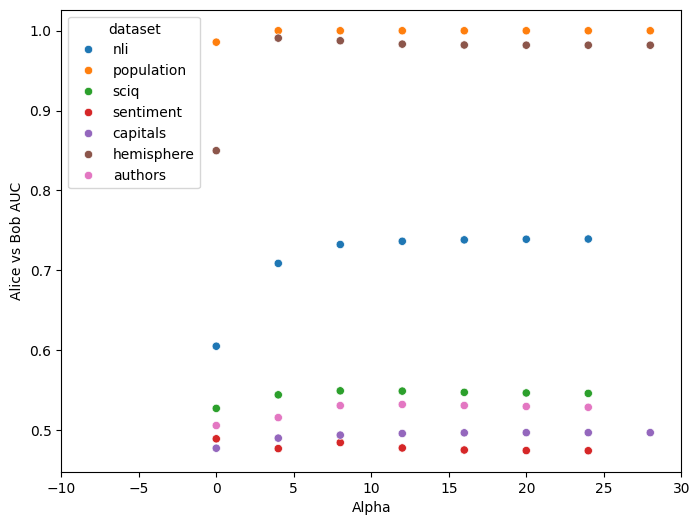

In [54]:
metrics = [
    ('auc_roc_all', 'auc_roc_train_from_test_all'),
    ('auc_roc_agree', 'auc_roc_train_from_test_agree'),
    ('auc_roc_disagree', 'auc_roc_train_from_test_disagree')
]

metrics_dict = {
    'auc_roc_all': 'Alice vs Bob AUC',
    'auc_roc_agree': 'Alice vs Bob AUC (Agree)',
    'auc_roc_disagree': 'Alice vs Bob AUC (Disagree)',
    'auc_roc_train_from_test_all': 'Train names vs Test names AUC',
    'auc_roc_train_from_test_agree': 'Train names vs Test names AUC (Agree)',
    'auc_roc_train_from_test_disagree': 'Train names vs Test names AUC (Disagree)'
}
df['layer']=df['layer'].astype(int)
df = df[~df['score'].isin(['lof', 'mahalanobis'])]

score_order = ['que', 'likelihood']
dataset_order = ['nli', 'population', 'sciq', 'sentiment', 'capitals', 'hemisphere', 'authors']

df['score'] = pd.Categorical(df['score'], categories=score_order, ordered=True)
df['dataset'] = pd.Categorical(df['dataset'], categories=dataset_order, ordered=True)


fix, ax = plt.subplots(figsize=(8, 6))

# sns.scatterplot(data = df, x='layer', y='auc_roc', ax=ax, hue='dataset')#, style='score')
sns.scatterplot(data = df_alpha, x='alpha', y='auc_roc', ax=ax, hue='dataset')
plt.xlabel('Alpha')
plt.ylabel('Alice vs Bob AUC')
# plt.xlim([18,33])
plt.xlim([-10,30])
# plt.ylim([0.4,1])

# corr_coef = df[['auc_roc', 'auc_roc_train_from_test']].corr().iloc[0, 1]
# print(f'Correlation coefficient between Alice vs Bob AUC and Train names vs Test names AUC: {corr_coef}')

